In [1]:
from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford, count_overlaps, solve_MIP
from helper import DynamicBundleStabilisation, solve_RMLP_with_bundle, better_pricing_problem_solver, new_duty_with_RCSP, new_duty_with_RCSP_priority, new_duty_with_bellman_ford_2

In [2]:
import importlib
import models
import gurobipy as gp 
from gurobipy import GRB
import helper

importlib.reload(models)
importlib.reload(helper)

from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford, count_overlaps, solve_MIP
from helper import DynamicBundleStabilisation, solve_RMLP_with_bundle, better_pricing_problem_solver, new_duty_with_RCSP, new_duty_with_RCSP_priority, new_duty_with_bellman_ford_2

In [3]:
services, service_dict = fetch_data('./StepBackServices.csv', partial=False, rakes = 20)       # 46 maximum number of rakes
graph = create_duty_graph(services)
print(graph)

DiGraph with 936 nodes and 140958 edges


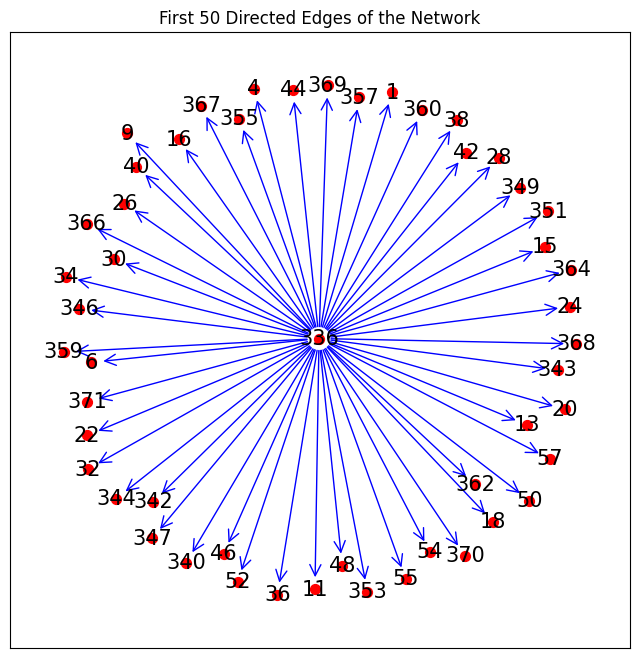

In [4]:
draw_graph_with_edges(graph)

In [5]:
def change_in_duals(curr_duals, prev_duals):
    count = 0
    for i, dual in enumerate(curr_duals):
        if abs(curr_duals[dual] - prev_duals[dual]) < 1e-3:
            count += 1
    print(f"Number of duals that are same is {count}")

In [13]:
init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit =45, show_logs = False, show_duties = False, show_roster_stats = False)
# init_duties, duty_count = simple_mpc(graph, service_dict, show_logs=False)
print(f"Initial number of duties: {len(init_duties)}")
cutoff_obj = len(init_duties)
print("For MPC method:", "\n")
all_covered = count_overlaps(init_duties, services)
print("\n")
init_duties2 = init_duties.copy()

prev_duals = {f"Service_{service.serv_num}": 0 for service in services}

for _ in range(100):
    # selected_duties, duals, selected_duty_vars, obj =  solve_RMLP_with_bundle(services=services, duties=init_duties2, bundle_stabiliser=bundle_stabiliser)
    selected_duties, duals, primal, obj = solve_RMLP(services=services, duties=init_duties2)
    change_in_duals(duals, prev_duals)
    prev_duals = duals
    # path, length, graph_cp = better_pricing_problem_solver(graph, duals = duals, prev_paths=init_duties2, epsilon = 1e-3)
    # path, length, graph_cp = new_duty_with_bellman_ford(graph, dual_values=duals)
    # path, length, labels = new_duty_with_RCSP_priority(graph, dual_values=duals, service_dict=service_dict, max_resource=60*6)
    path, length, labels = new_duty_with_bellman_ford_2(graph, dual_values=duals, service_dict=service_dict)
    print(_, path, obj, length)
    if path[1:-1] in init_duties2:
        print(f"iteration number {_} breaks......")
        break
    init_duties2.append(path[1:-1])

# print("IP starts solving.......")
# obj, selected_duties, model = solve_MIP(services, duties=init_duties2, cutoff=cutoff_obj, mipgap=0.01, timelimit=60*3)
# tt = []
# for duty_num in selected_duties:
#     tt.append(init_duties2[duty_num])
# count_overlaps(tt, services)

Initial number of duties: 131
For MPC method: 

Number of duties selected: 131
Total number of services: 934
Number of services that overlap in duties: 0
Number of services covered in duties: 934


Number of duals that are same is 803
0 [-2, 926, 928, 3, 349, 30, 730, 741, 752, 769, -1] 131.0 -9.0
Number of duals that are same is 916
1 [-2, 527, 929, 697, 703, 719, 83, 113, 772, 819, -1] 131.0 -9.0
Number of duals that are same is 916
2 [-2, 872, 693, 698, 704, 721, 104, 129, 777, -1] 131.0 -8.0
Number of duals that are same is 918
3 [-2, 876, 694, 699, 706, 724, 71, 395, 424, 448, -1] 131.0 -9.0
Number of duals that are same is 916
4 [-2, 877, 0, 700, 707, 723, 731, 742, 756, 766, -1] 131.0 -9.0
Number of duals that are same is 916
5 [-2, 927, 2, 346, 26, 60, 389, 429, 452, -1] 131.0 -8.0
Number of duals that are same is 918
6 [-2, 878, 695, 701, 715, 51, 384, 109, 779, -1] 131.0 -8.0
Number of duals that are same is 918
7 [-2, 881, 696, 12, 34, 729, 85, 183, -1] 131.0 -7.0
Number of 

In [14]:
print(init_duties2)

count = 0
for i, duty in enumerate(init_duties2):
    duty_time = 0
    for service in duty:
        for serv in services:
            if service == serv.serv_num:
                duty_time += serv.serv_dur
    
    if duty_time > 360:
        count += 1

    print(i, duty_time)
print(count)

[[336, 279, 850, 313, 514, 332, 932], [872, 297, 506, 326, 335, 526], [873, 411, 147, 783, 182, 203], [874, 406, 412, 418, 161, 790, 196], [875, 206, 459, 241, 831, 290, 502], [876, 264, 489, 300, 860, 327, 522], [877, 484, 291, 856, 320, 518], [878, 270, 492, 306, 862, 329, 523], [879, 373, 76, 106, 407, 139], [527, 548, 552, 566, 569, 572, 576, 582, 592, 597, 600, 603, 608, 611, 615, 618, 626, 630, 635, 639, 642], [880, 284, 499, 316, 867, 870], [926, 528, 530, 534, 537, 541, 545, 555, 558, 561, 564, 567, 631, 637, 640, 647, 651, 655, 686], [927, 276, 495, 311, 864, 331, 524], [0, 225, 470, 263, 842, 301, 912, 913], [881, 288, 501, 319, 868, 871], [928, 819, 256, 485, 293, 857, 321, 519], [693, 223, 469, 261, 841, 299, 507], [337, 273, 847, 308, 512, 330, 931, 691], [694, 756, 132, 420, 165, 792, 200], [883, 271, 296, 505, 324, 333, 525], [1, 112], [882, 817, 252, 483, 289, 855, 318, 517], [2, 24], [884, 479, 486, 295, 858, 323, 520], [929, 822, 262, 488, 298, 859, 325, 521], [695, 7

In [16]:
from collections import defaultdict

def compute_service_frequency(duties):
    """ computes how many times each service appears across all duties """
    service_count = defaultdict(int)
    for duty in duties:
        for service in duty:
            service_count[service] += 1
    return service_count

def find_critical_duties(duties, service_frequency):
    """ finds duties that contain unique services that no other duty covers """
    critical_duties = set()
    for duty_index, duty in enumerate(duties):
        for service in duty:
            if service_frequency[service] == 1:  # This service appears in only one duty
                critical_duties.add(duty_index)
                break
    return critical_duties

def solve_RMLP_with_hr(services, duties, fixed_duties=set()):
    model = gp.Model("CrewScheduling")
    model.setParam('OutputFlag', 0)
    
    duty_vars = {}
    for i in range(len(duties)):
        if i not in fixed_duties:
            duty_vars[i] = (model.addVar(vtype=GRB.CONTINUOUS, ub=1, lb=0, name=f"x{i}"))
            # duty_vars.append(model.addVar(vtype=GRB.CONTINUOUS, name=f"x{i}", lb=0.3, ub=0.5))
        # else:
        # duty_vars.append(model.addVar(vtype=GRB.CONTINUOUS, ub=1, lb=0, name=f"x{i}"))

    model.setObjective(gp.quicksum(duty_vars), GRB.MINIMIZE)

    service_constraints = []
    for service_idx, service in enumerate(services):
        constr = model.addConstr(
            gp.quicksum(duty_vars[duty_idx] for duty_idx, duty in enumerate(duties) if service.serv_num in duty and duty_idx not in fixed_duties) >= 0.95,
            name=f"Service_{service.serv_num}_lower")
        constr2 = model.addConstr(
            gp.quicksum(duty_vars[duty_idx] for duty_idx, duty in enumerate(duties) if service.serv_num in duty and duty_idx not in fixed_duties) <= 1.05,
            name=f"Service_{service.serv_num}_upper")

        service_constraints.append(constr)
        service_constraints.append(constr2)

    model.optimize()

    if model.status == GRB.INFEASIBLE:
        print('Infeasible problem!')
        return None, None, None, None, model
    elif model.status == GRB.OPTIMAL:
        objective = model.getObjective()
        dual_values = {f"Service_{service.serv_num}": constr.Pi for service, constr in zip(services, service_constraints)}
        primals = {v.varName: v.x for v in model.getVars()}
        selected_duties = [v for v in model.getVars()]
        return selected_duties, dual_values, primals, objective.getValue(), model
    else:
        print("No optimal solution found.")
        return None, None, None, None, model

def branching_heuristic(init_duties2, services, selected_duties=set(), depth=0):
    """ recursive sort of branch-and-bound heuristic for solving the integer program """
    print(f"[Depth {depth}] Solving RMLP with fixed {len(selected_duties)} duties...")
    
    selected_duties_list, dual_values, primals, objective_value, model = solve_RMLP_with_hr(services, init_duties2, selected_duties)
    if selected_duties_list is None:
        print("Infeasible RMLP, backtracking...")
        return selected_duties
    
    service_frequency = compute_service_frequency(init_duties2)
    critical_duties = find_critical_duties(init_duties2, service_frequency)
    selected_duties.update(critical_duties)
    
    high_value_duties = {int(v.varName[1:]) for v in selected_duties_list if v.x >= 0.8}
    selected_duties.update(high_value_duties)
    
    covered_services = set()
    for i in selected_duties:
        covered_services.update(init_duties2[i])
    
    if len(covered_services) == len(services):
        print("All services covered")
        return selected_duties
    
    remaining_duties = set(range(len(init_duties2))) - selected_duties
    best_duty = None
    max_unique_services = 0
    for duty in remaining_duties:
        uncovered_services = set(init_duties2[duty]) - covered_services
        if len(uncovered_services) > max_unique_services:
            max_unique_services = len(uncovered_services)
            best_duty = duty
    
    if best_duty is None:
        print("No more duties available to fix.")
        return selected_duties
    
    selected_duties.add(best_duty)
    print(selected_duties)
    return branching_heuristic(init_duties2, services, selected_duties, depth+1)

final_solution = branching_heuristic(init_duties2, services)

[Depth 0] Solving RMLP with fixed 0 duties...
All services covered


In [17]:
branching_heuristic_duties = []

for duty_num in final_solution:
    branching_heuristic_duties.append(init_duties2[duty_num])

print(" ")
count_overlaps(branching_heuristic_duties, services)

 
Number of duties selected: 131
Total number of services: 934
Number of services that overlap in duties: 0
Number of services covered in duties: 934


True

In [10]:
from collections import defaultdict

def compute_service_frequency(duties):
    """Computes the frequency of each service across all duties."""
    service_frequency = defaultdict(int)
    for duty in duties:
        for service in duty:
            service_frequency[service] += 1
    return service_frequency

def find_critical_duties(duties, service_frequency):
    """Finds duties that contain unique services that no other duty covers."""
    critical_duties = set()
    for duty_index, duty in enumerate(duties):
        for service in duty:
            if service_frequency[service] == 1:  # This service is unique to this duty
                critical_duties.add(duty_index)
                break  # No need to check further; this duty is required
    return critical_duties

def cal_coverage(duty, covered_services, service_frequency):
    """Returns newly covered services and a score that prioritizes rare service coverage."""
    new_services = set(duty) - covered_services
    overlap = len(set(duty) & covered_services)

    # Score prioritizes rare services and penalizes overlap
    rare_services_score = sum(2 / service_frequency[service] for service in new_services)
    score = rare_services_score - 4 * overlap  # Penalize overlap more strongly

    return new_services, score

def greedy_heuristic(duties, services):
    """Greedy heuristic that ensures unique services are covered first and minimizes overlap."""
    selected_cols = set()
    covered_services = set()
    remaining_cols = list(range(len(duties)))  # Store indices instead of full duties
    service_frequency = compute_service_frequency(duties)  # Get service frequency

    # **Step 1: Select critical duties (ensuring unique services are covered)**
    critical_duties = find_critical_duties(duties, service_frequency)
    selected_cols.update(critical_duties)
    
    for duty_index in critical_duties:
        covered_services.update(duties[duty_index])
        remaining_cols.remove(duty_index)

    # **Step 2: Greedy selection to minimize overlap and ensure full coverage**
    while len(covered_services) < len(services):
        best_col = None
        max_score = float('-inf')

        for col_num in remaining_cols:
            new_services, score = cal_coverage(duties[col_num], covered_services, service_frequency)

            if score > max_score:
                max_score = score
                best_col = col_num

        if best_col is None:
            break  # Stop if no more good choices exist

        # Add the best duty and update coverage
        selected_cols.add(best_col)
        best_col_services, _ = cal_coverage(duties[best_col], covered_services, service_frequency)
        covered_services.update(best_col_services)

        # Remove selected duty
        remaining_cols.remove(best_col)

    # **Step 3: Post-processing to guarantee full coverage**
    uncovered_services = set(services) - covered_services
    if uncovered_services:
        print(f"⚠️ Post-processing: {len(uncovered_services)} services are still uncovered.")

        while uncovered_services:
            # Pick a duty that covers the most missing services
            best_col = None
            max_new_coverage = 0

            for col_num in remaining_cols:
                new_coverage = len(set(duties[col_num]) & uncovered_services)
                if new_coverage > max_new_coverage:
                    max_new_coverage = new_coverage
                    best_col = col_num

            if best_col is None:
                print("⚠️ No feasible duty found for uncovered services!")
                break

            # Add the duty that covers the most missing services
            selected_cols.add(best_col)
            covered_services.update(duties[best_col])
            uncovered_services = set(services) - covered_services

    return selected_cols

# Run the heuristic
greedy_duties = greedy_heuristic(init_duties2, services)
print(f"✅ Greedy duties selected: {len(greedy_duties)}")

greedily_selected_duties = []

for duty_num in greedy_duties:
    greedily_selected_duties.append(init_duties2[duty_num])

print(" ")
count_overlaps(greedily_selected_duties, services)

⚠️ Post-processing: 934 services are still uncovered.
⚠️ No feasible duty found for uncovered services!
✅ Greedy duties selected: 131
 
Number of duties selected: 131
Total number of services: 934
Number of services that overlap in duties: 0
Number of services covered in duties: 934


True

In [11]:
# block to write selected duties to csv file

output_filename = "duties_after_gen/duties_after_gen_701_all.csv"

with open(output_filename, mode="w", newline="") as file:
    # Define column headers
    fieldnames = [
        "Service Number", "Train Number", "Start Station", "Start Time (mins)", 
        "End Station", "End Time (mins)", "Direction", "Service Duration", 
        "Jurisdiction", "Stepback Train Number", "Break Duration", "Trip Duration",
        "Duty Duration"  # New column for total duty duration
    ]
    
    writer = csv.writer(file)
    writer.writerow(fieldnames)  # Write header

    for duty in selected_duties:
        # Calculate total duty duration (from first service start time to last service end time)
        valid_services = [service_dict[s] for s in duty if s in service_dict]
        if valid_services:
            duty_start_time = min(s.start_time for s in valid_services)
            duty_end_time = max(s.end_time for s in valid_services)
            total_duty_duration = duty_end_time - duty_start_time

            for service in valid_services:
                writer.writerow([
                    service.serv_num, service.train_num, service.start_stn, service.start_time,
                    service.end_stn, service.end_time, service.direction, service.serv_dur,
                    service.jurisdiction, service.stepback_train_num, service.break_dur, service.trip_dur,
                    total_duty_duration  # Add total duty duration for each service
                ])
        writer.writerow([])  # Add an empty row to separate duties

print(f"CSV file '{output_filename}' generated successfully.")

NameError: name 'csv' is not defined